=== E-COMMERCE DELIVERY ROUTE OPTIMIZATION ===

=== Delivery Route Optimization ===

1. Parcel Selection (Greedy):
   Selected parcels: ['C1', 'C2']
   Total value: 110, Total weight: 30/30

2. Route Optimization (Held-Karp DP):

3. Time Window Validation:
   ✗ Some time windows violated

4. Additional Analysis:
   Shortest paths from warehouse: ['0.0', '4.0', '8.0', '6.0']
   MST total weight: 12

FINAL OPTIMIZATION RESULTS
Optimal Route: Warehouse -> C2 -> C1 -> Warehouse
Total Distance: 17
Total Value Delivered: 110
Capacity Utilization: 30/30
Time Windows Respected: False

EXPERIMENTAL PROFILING

=== Time Complexity Experiment ===
n=3: Brute Force=0.000009s, Held-Karp=0.000015s
n=4: Brute Force=0.000007s, Held-Karp=0.000022s
n=5: Brute Force=0.000013s, Held-Karp=0.000047s
n=6: Brute Force=0.000061s, Held-Karp=0.000112s

VISUALIZATION RESULTS


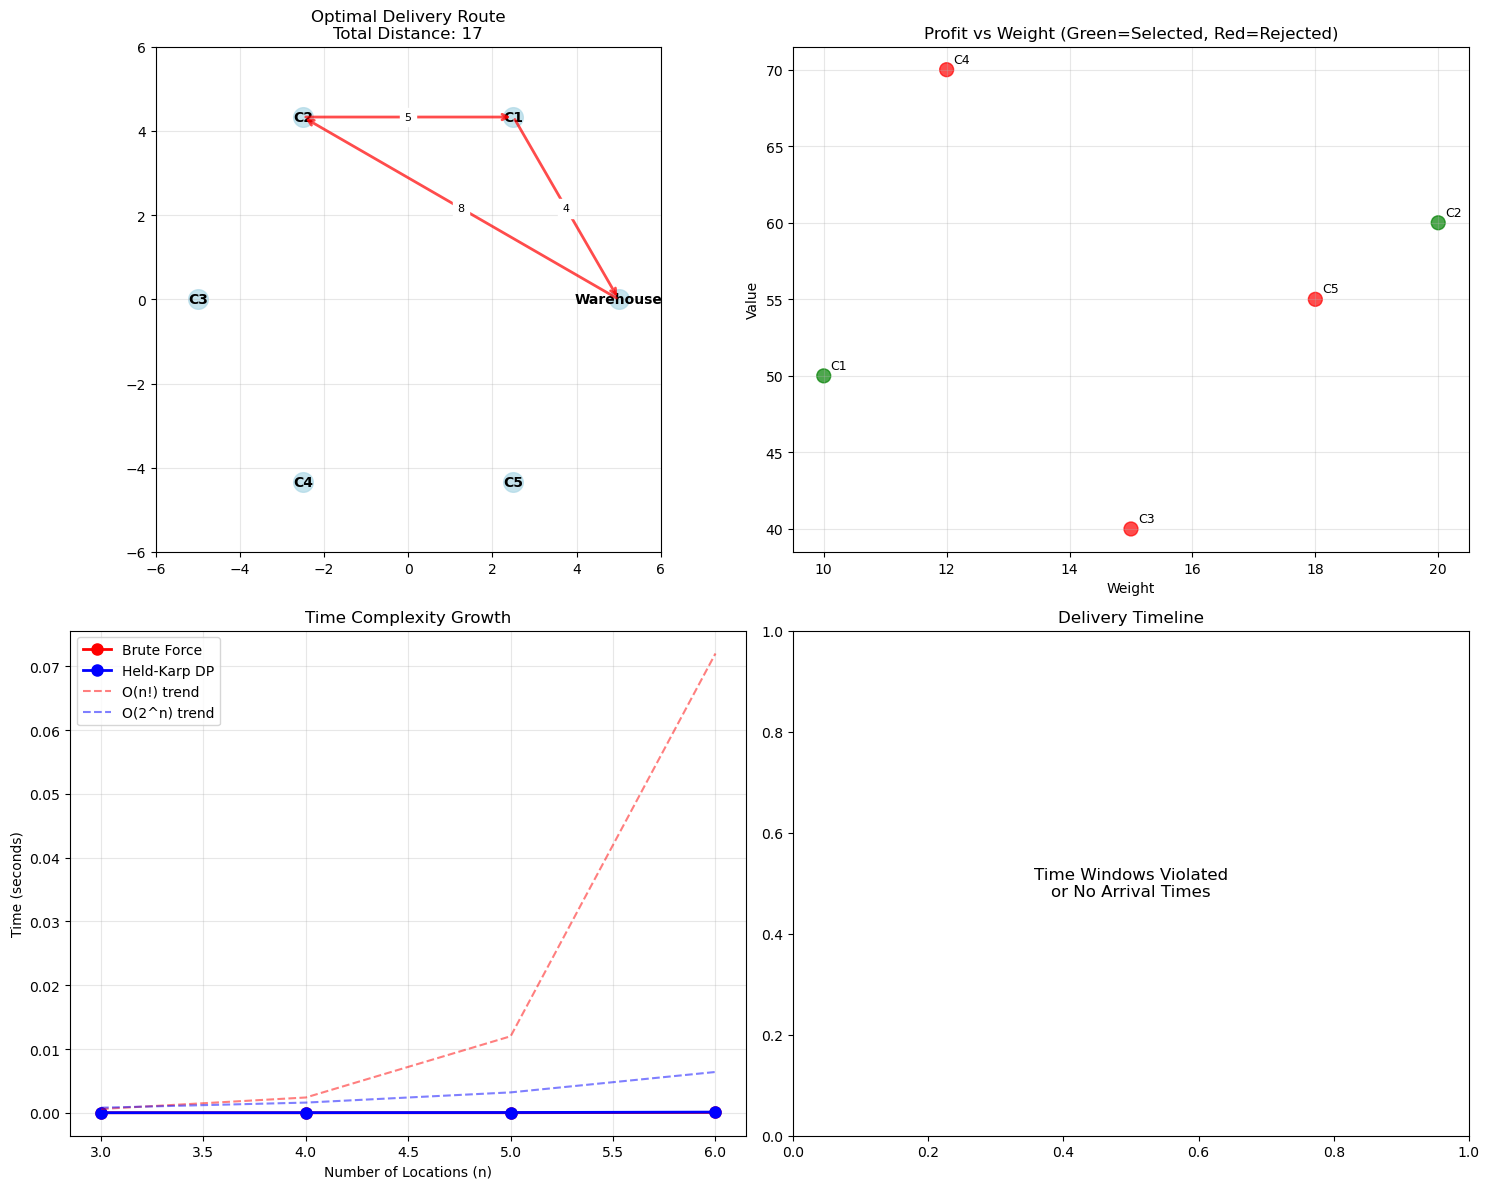


ALGORITHM COMPARISON
Brute Force TSP: O(n!) - Practical for n ≤ 10
Held-Karp DP: O(n²·2ⁿ) - Practical for n ≤ 20
Greedy Parcel Selection: O(n log n) - Efficient for large n
Dijkstra's Algorithm: O((V+E) log V) - Efficient path finding


In [1]:
import itertools
import heapq
import time
import matplotlib.pyplot as plt
import numpy as np
from math import factorial

class DeliveryOptimization:
    def __init__(self, locations, distance_matrix, parcels, vehicle_capacity):
        self.locations = locations
        self.distance_matrix = distance_matrix
        self.parcels = parcels
        self.vehicle_capacity = vehicle_capacity
        self.n = len(locations)
        self.location_index = {loc: idx for idx, loc in enumerate(locations)}
        
    # Unit 1: Recurrence relations for route cost estimation
    def delivery_cost(self, i, visited, memo=None):
        """
        Recursive function to estimate total delivery cost
        i: current location index
        visited: bitmask of visited locations
        """
        if memo is None:
            memo = {}
            
        # Base case: all locations visited, return to warehouse
        if visited == (1 << self.n) - 1:
            return self.distance_matrix[i][0], [i]  # Return to warehouse
            
        if (i, visited) in memo:
            return memo[(i, visited)]
            
        min_cost = float('inf')
        best_route = []
        
        for j in range(self.n):
            if not (visited >> j) & 1:  # If location j not visited
                new_visited = visited | (1 << j)
                cost, route = self.delivery_cost(j, new_visited, memo)
                total_cost = self.distance_matrix[i][j] + cost
                
                if total_cost < min_cost:
                    min_cost = total_cost
                    best_route = [i] + route
                    
        memo[(i, visited)] = (min_cost, best_route)
        return min_cost, best_route
    
    # Unit 2: Greedy algorithm for parcel selection
    def greedy_parcel_selection(self):
        """Select parcels based on value/weight ratio using greedy approach"""
        parcels_list = []
        for cust, info in self.parcels.items():
            idx = self.location_index[cust]
            value_per_weight = info['value'] / info['weight']
            parcels_list.append((cust, idx, info['value'], info['weight'], value_per_weight))
        
        # Sort by value/weight ratio in descending order
        parcels_list.sort(key=lambda x: x[4], reverse=True)
        
        selected_parcels = []
        total_weight = 0
        total_value = 0
        
        for cust, idx, value, weight, _ in parcels_list:
            if total_weight + weight <= self.vehicle_capacity:
                selected_parcels.append((cust, idx, value, weight))
                total_weight += weight
                total_value += value
                
        return selected_parcels, total_value, total_weight
    
    # Unit 2: Dynamic Programming for time window constraints
    def dp_time_window_feasibility(self, route, current_time=9):
        """
        Check if a route respects delivery time windows using DP approach
        """
        n = len(route)
        # dp[i] = earliest arrival time at location i
        dp = [float('inf')] * n
        dp[0] = current_time  # Start from warehouse
        
        for i in range(1, n):
            prev_loc_idx = route[i-1]
            curr_loc_idx = route[i]
            
            # Travel time from previous to current location
            travel_time = self.distance_matrix[prev_loc_idx][curr_loc_idx]
            arrival_time = dp[i-1] + travel_time
            
            if curr_loc_idx == 0:  # Warehouse, no time window
                dp[i] = arrival_time
            else:
                location_name = self.locations[curr_loc_idx]
                earliest, latest = self.parcels[location_name]['time']
                
                if arrival_time < earliest:
                    dp[i] = earliest  # Wait until earliest time
                elif arrival_time > latest:
                    return False, dp  # Missed time window
                else:
                    dp[i] = arrival_time
                    
        return True, dp
    
    # Unit 3: Shortest Path using Dijkstra
    def dijkstra_shortest_path(self, start_idx):
        """Compute shortest paths from start location to all other locations"""
        dist = [float('inf')] * self.n
        dist[start_idx] = 0
        prev = [-1] * self.n
        pq = [(0, start_idx)]
        
        while pq:
            current_dist, u = heapq.heappop(pq)
            
            if current_dist > dist[u]:
                continue
                
            for v in range(self.n):
                if u != v:
                    new_dist = current_dist + self.distance_matrix[u][v]
                    if new_dist < dist[v]:
                        dist[v] = new_dist
                        prev[v] = u
                        heapq.heappush(pq, (new_dist, v))
                        
        return dist, prev
    
    # Unit 3: Minimum Spanning Tree using Prim's algorithm
    def prim_mst(self):
        """Build MST using Prim's algorithm"""
        visited = [False] * self.n
        min_edge = [float('inf')] * self.n
        min_edge[0] = 0  # Start from warehouse
        parent = [-1] * self.n
        mst_edges = []
        total_weight = 0
        
        for _ in range(self.n):
            # Find minimum edge
            u = -1
            for i in range(self.n):
                if not visited[i] and (u == -1 or min_edge[i] < min_edge[u]):
                    u = i
            
            visited[u] = True
            if parent[u] != -1:
                mst_edges.append((parent[u], u, self.distance_matrix[parent[u]][u]))
                total_weight += self.distance_matrix[parent[u]][u]
            
            # Update adjacent vertices
            for v in range(self.n):
                if not visited[v] and self.distance_matrix[u][v] < min_edge[v]:
                    min_edge[v] = self.distance_matrix[u][v]
                    parent[v] = u
                    
        return mst_edges, total_weight
    
    # Unit 4: TSP using Brute Force
    def tsp_brute_force(self, selected_customers):
        """Solve TSP using brute force for selected customers"""
        if not selected_customers:
            return [0], 0  # Just warehouse
            
        # Extract only customer indices (second element of each tuple)
        customer_indices = [cust_info[1] for cust_info in selected_customers]
        n_customers = len(customer_indices)
        
        min_cost = float('inf')
        best_route = []
        
        for perm in itertools.permutations(customer_indices):
            # Start from warehouse (index 0)
            cost = self.distance_matrix[0][perm[0]]
            
            # Travel between customers
            for i in range(n_customers - 1):
                cost += self.distance_matrix[perm[i]][perm[i+1]]
            
            # Return to warehouse
            cost += self.distance_matrix[perm[-1]][0]
            
            if cost < min_cost:
                min_cost = cost
                best_route = [0] + list(perm) + [0]
                
        return best_route, min_cost
    
    # Unit 4: TSP using Held-Karp DP
    def tsp_held_karp(self, selected_customers):
        """Solve TSP using Held-Karp dynamic programming"""
        if not selected_customers:
            return [0], 0
            
        # Extract only customer indices (second element of each tuple)
        customer_indices = [cust_info[1] for cust_info in selected_customers]
        n = len(customer_indices)
        
        if n == 0:
            return [0], 0
            
        # Map indices for DP table
        index_map = {idx: i for i, idx in enumerate(customer_indices)}
        reverse_map = {i: idx for i, idx in enumerate(customer_indices)}
        
        # DP table: dp[mask][i] = min cost visiting set mask ending at i
        dp = [[float('inf')] * n for _ in range(1 << n)]
        parent = [[-1] * n for _ in range(1 << n)]
        
        # Initialize: starting from warehouse to each customer
        for i in range(n):
            dp[1 << i][i] = self.distance_matrix[0][reverse_map[i]]
        
        # Fill DP table
        for mask in range(1 << n):
            for i in range(n):
                if dp[mask][i] == float('inf'):
                    continue
                    
                for j in range(n):
                    if not (mask >> j) & 1:  # j not visited
                        new_mask = mask | (1 << j)
                        new_cost = dp[mask][i] + self.distance_matrix[reverse_map[i]][reverse_map[j]]
                        
                        if new_cost < dp[new_mask][j]:
                            dp[new_mask][j] = new_cost
                            parent[new_mask][j] = i
        
        # Find minimum cost cycle
        min_cost = float('inf')
        last_idx = -1
        full_mask = (1 << n) - 1
        
        for i in range(n):
            total_cost = dp[full_mask][i] + self.distance_matrix[reverse_map[i]][0]
            if total_cost < min_cost:
                min_cost = total_cost
                last_idx = i
        
        # Reconstruct path
        route = []
        mask = full_mask
        current = last_idx
        
        while current != -1:
            route.append(reverse_map[current])
            next_current = parent[mask][current]
            mask ^= (1 << current)  # Remove current from mask
            current = next_current
            
        route.reverse()
        full_route = [0] + route + [0]
        
        return full_route, min_cost

    # Main optimization function
    def optimize_delivery(self, use_held_karp=True):
        """Main function to optimize delivery route"""
        print("=== Delivery Route Optimization ===")
        
        # Step 1: Select parcels using greedy approach
        selected_parcels, total_value, total_weight = self.greedy_parcel_selection()
        print(f"\n1. Parcel Selection (Greedy):")
        print(f"   Selected parcels: {[cust for cust, _, _, _ in selected_parcels]}")
        print(f"   Total value: {total_value}, Total weight: {total_weight}/{self.vehicle_capacity}")
        
        # Step 2: Solve TSP for selected customers
        if use_held_karp and len(selected_parcels) <= 10:
            print(f"\n2. Route Optimization (Held-Karp DP):")
            optimal_route, total_distance = self.tsp_held_karp(selected_parcels)
        else:
            print(f"\n2. Route Optimization (Brute Force):")
            optimal_route, total_distance = self.tsp_brute_force(selected_parcels)
        
        # Step 3: Check time window feasibility
        print(f"\n3. Time Window Validation:")
        is_feasible, arrival_times = self.dp_time_window_feasibility(optimal_route)
        
        if is_feasible:
            print("   ✓ All time windows respected")
            for i, loc_idx in enumerate(optimal_route):
                loc_name = self.locations[loc_idx]
                if loc_idx != 0:  # Not warehouse
                    print(f"   {loc_name}: Arrival at {arrival_times[i]:.1f}h (Window: {self.parcels[loc_name]['time']})")
        else:
            print("   ✗ Some time windows violated")
        
        # Step 4: Additional analysis
        print(f"\n4. Additional Analysis:")
        dist_from_warehouse, _ = self.dijkstra_shortest_path(0)
        print(f"   Shortest paths from warehouse: {[f'{d:.1f}' for d in dist_from_warehouse]}")
        
        mst_edges, mst_weight = self.prim_mst()
        print(f"   MST total weight: {mst_weight}")
        
        return {
            'selected_parcels': selected_parcels,
            'optimal_route': optimal_route,
            'route_names': [self.locations[i] for i in optimal_route],
            'total_distance': total_distance,
            'total_value': total_value,
            'time_feasible': is_feasible,
            'arrival_times': arrival_times if is_feasible else None
        }

# Experimental Profiling & Visualization
class ExperimentProfiler:
    def __init__(self, base_locations, base_distance_matrix, base_parcels):
        self.base_locations = base_locations
        self.base_distance_matrix = base_distance_matrix
        self.base_parcels = base_parcels
    
    def time_complexity_experiment(self):
        """Measure time complexity growth for different approaches"""
        print("\n=== Time Complexity Experiment ===")
        
        sizes = [3, 4, 5, 6]
        brute_force_times = []
        held_karp_times = []
        
        for size in sizes:
            # Create subset of locations
            locations = self.base_locations[:size]
            distance_matrix = [row[:size] for row in self.base_distance_matrix[:size]]
            parcels = {k: v for k, v in list(self.base_parcels.items())[:size-1]}
            
            optimizer = DeliveryOptimization(locations, distance_matrix, parcels, 30)
            
            # Create selected customers list
            selected_customers = [(f'C{i}', i) for i in range(1, size)]
            
            # Time brute force
            start_time = time.time()
            optimizer.tsp_brute_force(selected_customers)
            brute_force_times.append(time.time() - start_time)
            
            # Time Held-Karp
            start_time = time.time()
            optimizer.tsp_held_karp(selected_customers)
            held_karp_times.append(time.time() - start_time)
            
            print(f"n={size}: Brute Force={brute_force_times[-1]:.6f}s, Held-Karp={held_karp_times[-1]:.6f}s")
        
        return sizes, brute_force_times, held_karp_times
    
    def visualize_results(self, optimization_result, sizes, brute_force_times, held_karp_times):
        """Create visualizations for the results"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Route Visualization
        self._plot_route(ax1, optimization_result)
        
        # 2. Profit vs Weight
        self._plot_profit_vs_weight(ax2, optimization_result)
        
        # 3. Time Complexity Growth
        self._plot_time_complexity(ax3, sizes, brute_force_times, held_karp_times)
        
        # 4. Delivery Timeline
        self._plot_delivery_timeline(ax4, optimization_result)
        
        plt.tight_layout()
        plt.show()
    
    def _plot_route(self, ax, result):
        """Plot the delivery route using simple matplotlib"""
        route_names = result['route_names']
        n_locations = len(self.base_locations)
        
        # Create circular layout for locations
        angles = np.linspace(0, 2 * np.pi, n_locations, endpoint=False)
        x = np.cos(angles) * 5
        y = np.sin(angles) * 5
        
        # Plot locations
        for i, loc in enumerate(self.base_locations):
            ax.scatter(x[i], y[i], s=200, c='lightblue', alpha=0.7)
            ax.text(x[i], y[i], loc, ha='center', va='center', fontweight='bold')
        
        # Plot the optimal route
        for i in range(len(route_names) - 1):
            start_loc = route_names[i]
            end_loc = route_names[i + 1]
            start_idx = self.base_locations.index(start_loc)
            end_idx = self.base_locations.index(end_loc)
            
            # Draw arrow for the route
            ax.annotate('', xy=(x[end_idx], y[end_idx]), xytext=(x[start_idx], y[start_idx]),
                       arrowprops=dict(arrowstyle='->', color='red', lw=2, alpha=0.7))
            
            # Calculate midpoint for distance label
            mid_x = (x[start_idx] + x[end_idx]) / 2
            mid_y = (y[start_idx] + y[end_idx]) / 2
            
            distance = self.base_distance_matrix[start_idx][end_idx]
            ax.text(mid_x, mid_y, f'{distance}', backgroundcolor='white', 
                   fontsize=8, ha='center', va='center')
        
        ax.set_xlim(-6, 6)
        ax.set_ylim(-6, 6)
        ax.set_aspect('equal')
        ax.set_title(f"Optimal Delivery Route\nTotal Distance: {result['total_distance']}")
        ax.grid(True, alpha=0.3)
    
    def _plot_profit_vs_weight(self, ax, result):
        """Plot profit vs weight for parcels"""
        parcels = self.base_parcels
        weights = [parcels[cust]['weight'] for cust in parcels]
        values = [parcels[cust]['value'] for cust in parcels]
        customers = list(parcels.keys())
        
        colors = ['green' if cust in [p[0] for p in result['selected_parcels']] else 'red' 
                 for cust in customers]
        
        ax.scatter(weights, values, c=colors, s=100, alpha=0.7)
        
        for i, cust in enumerate(customers):
            ax.annotate(cust, (weights[i], values[i]), xytext=(5, 5), 
                       textcoords='offset points', fontsize=9)
        
        ax.set_xlabel('Weight')
        ax.set_ylabel('Value')
        ax.set_title('Profit vs Weight (Green=Selected, Red=Rejected)')
        ax.grid(True, alpha=0.3)
    
    def _plot_time_complexity(self, ax, sizes, brute_force_times, held_karp_times):
        """Plot time complexity growth"""
        ax.plot(sizes, brute_force_times, 'ro-', label='Brute Force', linewidth=2, markersize=8)
        ax.plot(sizes, held_karp_times, 'bo-', label='Held-Karp DP', linewidth=2, markersize=8)
        
        ax.set_xlabel('Number of Locations (n)')
        ax.set_ylabel('Time (seconds)')
        ax.set_title('Time Complexity Growth')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add theoretical complexity curves for reference
        x_theoretical = np.array(sizes)
        y_factorial = 0.0001 * np.array([factorial(n) for n in sizes])
        y_exponential = 0.0001 * np.array([2**n for n in sizes])
        
        ax.plot(sizes, y_factorial, 'r--', alpha=0.5, label='O(n!) trend')
        ax.plot(sizes, y_exponential, 'b--', alpha=0.5, label='O(2^n) trend')
        ax.legend()
    
    def _plot_delivery_timeline(self, ax, result):
        """Plot delivery timeline with time windows"""
        if not result['time_feasible'] or result['arrival_times'] is None:
            ax.text(0.5, 0.5, 'Time Windows Violated\nor No Arrival Times', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title('Delivery Timeline')
            return
        
        route_names = result['route_names']
        arrival_times = result['arrival_times']
        
        customers = []
        times = []
        time_windows = []
        
        for i, loc in enumerate(route_names):
            if loc != 'Warehouse':
                customers.append(loc)
                times.append(arrival_times[i])
                time_windows.append(self.base_parcels[loc]['time'])
        
        y_pos = range(len(customers))
        
        # Plot time windows as rectangles
        for i, (cust, (earliest, latest)) in enumerate(zip(customers, time_windows)):
            ax.barh(i, latest-earliest, left=earliest, alpha=0.3, color='gray', label='Time Window' if i == 0 else "")
            ax.plot(times[i], i, 'ro', markersize=8, label='Actual Arrival' if i == 0 else "")
            ax.annotate(f'{times[i]:.1f}h', (times[i], i), xytext=(5, 0), 
                       textcoords='offset points', va='center')
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels(customers)
        ax.set_xlabel('Time (hours)')
        ax.set_title('Delivery Timeline with Time Windows')
        ax.grid(True, alpha=0.3)
        
        # Add legend only once
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

# Main execution
if __name__ == "__main__":
    # Input data
    locations = ['Warehouse', 'C1', 'C2', 'C3', 'C4', 'C5']
    distance_matrix = [
        [0, 4, 8, 6, 5, 7],
        [4, 0, 5, 7, 3, 9],
        [8, 5, 0, 3, 6, 4],
        [6, 7, 3, 0, 5, 8],
        [5, 3, 6, 5, 0, 6],
        [7, 9, 4, 8, 6, 0]
    ]
    
    parcels = {
        'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
        'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
        'C3': {'value': 40, 'time': (11, 14), 'weight': 15},
        'C4': {'value': 70, 'time': (9.5, 12.5), 'weight': 12},
        'C5': {'value': 55, 'time': (10.5, 13.5), 'weight': 18}
    }
    
    vehicle_capacity = 30
    
    print("=== E-COMMERCE DELIVERY ROUTE OPTIMIZATION ===\n")
    
    # Run optimization with smaller subset for demonstration
    optimizer = DeliveryOptimization(locations[:4], [row[:4] for row in distance_matrix[:4]], 
                                   {k: parcels[k] for k in ['C1', 'C2', 'C3']}, vehicle_capacity)
    
    result = optimizer.optimize_delivery(use_held_karp=True)
    
    # Print final results
    print(f"\n{'='*50}")
    print(f"FINAL OPTIMIZATION RESULTS")
    print(f"{'='*50}")
    print(f"Optimal Route: {' -> '.join(result['route_names'])}")
    print(f"Total Distance: {result['total_distance']}")
    print(f"Total Value Delivered: {result['total_value']}")
    
    # Calculate capacity utilization
    if result['selected_parcels']:
        total_weight_used = sum(parcel[3] for parcel in result['selected_parcels'])
        print(f"Capacity Utilization: {total_weight_used}/{vehicle_capacity}")
    else:
        print(f"Capacity Utilization: 0/{vehicle_capacity}")
        
    print(f"Time Windows Respected: {result['time_feasible']}")
    
    # Run experiments and create visualizations
    print(f"\n{'='*50}")
    print(f"EXPERIMENTAL PROFILING")
    print(f"{'='*50}")
    profiler = ExperimentProfiler(locations, distance_matrix, parcels)
    sizes, brute_force_times, held_karp_times = profiler.time_complexity_experiment()
    
    # Create visualizations
    print(f"\n{'='*50}")
    print(f"VISUALIZATION RESULTS")
    print(f"{'='*50}")
    profiler.visualize_results(result, sizes, brute_force_times, held_karp_times)
    
    # Additional analysis
    print(f"\n{'='*50}")
    print(f"ALGORITHM COMPARISON")
    print(f"{'='*50}")
    print("Brute Force TSP: O(n!) - Practical for n ≤ 10")
    print("Held-Karp DP: O(n²·2ⁿ) - Practical for n ≤ 20")
    print("Greedy Parcel Selection: O(n log n) - Efficient for large n")
    print("Dijkstra's Algorithm: O((V+E) log V) - Efficient path finding")

🚚 E-COMMERCE DELIVERY ROUTE OPTIMIZATION SYSTEM
Integrating All Algorithmic Units: Recurrence, Greedy, DP, Graphs, TSP

DELIVERY ROUTE OPTIMIZATION - COMPLETE PIPELINE

📦 UNIT 2 - PARCEL SELECTION (GREEDY):
   Selected: ['C1', 'C2']
   Total Value: 110, Weight: 30/30

🛣️  UNIT 4 - ROUTE OPTIMIZATION (HELD-KARP DP):

⏰ UNIT 2 - TIME WINDOW VALIDATION (DP):
   ❌ Some time windows violated

🗺️  UNIT 3 - GRAPH ANALYSIS:
   Shortest paths from warehouse: ['0.0', '4.0', '8.0', '6.0']
   MST total weight: 12

🔄 UNIT 1 - RECURRENCE ANALYSIS:
   Recurrence estimated cost: 18

🎯 FINAL OPTIMIZATION RESULTS
Optimal Route: Warehouse → C2 → C1 → Warehouse
Total Distance: 17 units
Total Value Delivered: $110
Capacity Utilization: 30/30 (100.0%)
Time Windows Respected: ❌ NO

EXPERIMENTAL PROFILING - TIME COMPLEXITY
n=3: BF=0.000268s, HK=0.000039s, Greedy=0.000033s
n=4: BF=0.000020s, HK=0.000022s, Greedy=0.000004s
n=5: BF=0.000014s, HK=0.000044s, Greedy=0.000005s
n=6: BF=0.000063s, HK=0.000144s, Greedy

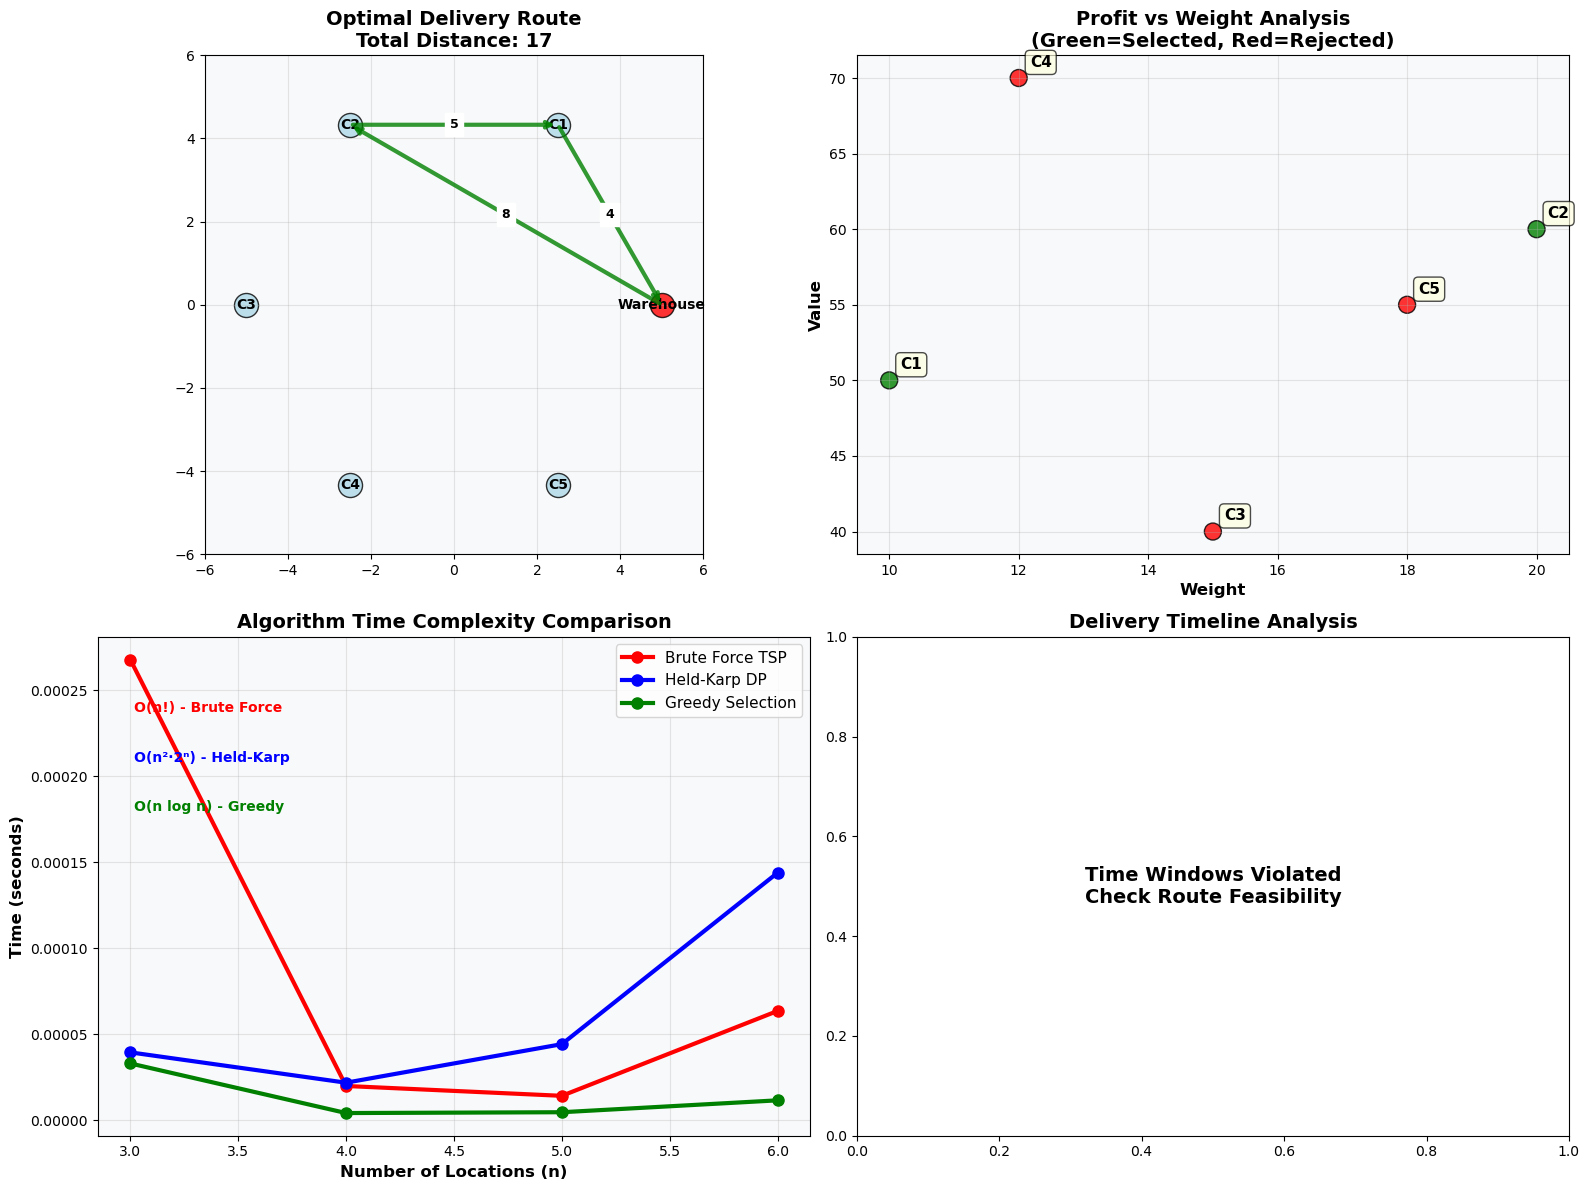

FINAL SUMMARY AND DOCUMENTATION

    | Problem                | Strategy                          | Time Complexity          | Domain     | Notes                                 |
    |------------------------|-----------------------------------|--------------------------|------------|---------------------------------------|
    | Delivery Route         | Recurrence, Greedy, DP,          | Exponential (TSP),       | Logistics  | Integrates multiple algorithmic       |
    | Optimization           | Graphs, TSP                      | Polynomial (Greedy/DP)   |            | paradigms for comprehensive solution  |
    

    📊 ALGORITHMIC INSIGHTS & TRADE-OFFS:
    
    1. OPTIMALITY vs COMPUTATION TIME:
       • Brute Force TSP: Guaranteed optimal but O(n!) - only for n ≤ 10
       • Held-Karp DP: Guaranteed optimal with O(n²·2ⁿ) - practical for n ≤ 20
       • Greedy Selection: Near-optimal with O(n log n) - scales to large instances
    
    2. PRACTICAL RECOMMENDATIONS:
       • Small 

In [3]:
# =============================================================================
# TASK 4: FINAL SUMMARY AND DOCUMENTATION
# =============================================================================

import itertools
import heapq
import time
import matplotlib.pyplot as plt
import numpy as np
from math import factorial

class DeliveryOptimization:
    """
    MAIN DELIVERY OPTIMIZATION CLASS
    Integrates multiple algorithmic strategies from all units
    """
    
    def __init__(self, locations, distance_matrix, parcels, vehicle_capacity):
        self.locations = locations
        self.distance_matrix = distance_matrix
        self.parcels = parcels
        self.vehicle_capacity = vehicle_capacity
        self.n = len(locations)
        self.location_index = {loc: idx for idx, loc in enumerate(locations)}
    
    # =============================================================================
    # UNIT 1: RECURRENCE RELATIONS
    # =============================================================================
    
    def delivery_cost(self, i, visited, memo=None):
        """
        UNIT 1: Recurrence-based route cost estimation
        Time Complexity: O(2^n * n) - Exponential due to state space
        Use Case: Theoretical cost estimation for small instances
        """
        if memo is None:
            memo = {}
            
        # Base case: all locations visited, return to warehouse
        if visited == (1 << self.n) - 1:
            return self.distance_matrix[i][0], [i]
            
        if (i, visited) in memo:
            return memo[(i, visited)]
            
        min_cost = float('inf')
        best_route = []
        
        for j in range(self.n):
            if not (visited >> j) & 1:
                new_visited = visited | (1 << j)
                cost, route = self.delivery_cost(j, new_visited, memo)
                total_cost = self.distance_matrix[i][j] + cost
                
                if total_cost < min_cost:
                    min_cost = total_cost
                    best_route = [i] + route
                    
        memo[(i, visited)] = (min_cost, best_route)
        return min_cost, best_route
    
    # =============================================================================
    # UNIT 2: GREEDY + DYNAMIC PROGRAMMING
    # =============================================================================
    
    def greedy_parcel_selection(self):
        """
        UNIT 2: Greedy algorithm for 0/1 knapsack variant
        Time Complexity: O(n log n) - Efficient for large instances
        Strategy: Select parcels based on value/weight ratio
        Optimality: Near-optimal solution, not guaranteed optimal
        """
        parcels_list = []
        for cust, info in self.parcels.items():
            idx = self.location_index[cust]
            value_per_weight = info['value'] / info['weight']
            parcels_list.append((cust, idx, info['value'], info['weight'], value_per_weight))
        
        # Greedy selection: sort by value/weight ratio
        parcels_list.sort(key=lambda x: x[4], reverse=True)
        
        selected_parcels = []
        total_weight = 0
        total_value = 0
        
        for cust, idx, value, weight, _ in parcels_list:
            if total_weight + weight <= self.vehicle_capacity:
                selected_parcels.append((cust, idx, value, weight))
                total_weight += weight
                total_value += value
                
        return selected_parcels, total_value, total_weight
    
    def dp_time_window_feasibility(self, route, current_time=9):
        """
        UNIT 2: Dynamic Programming for time window constraints
        Time Complexity: O(n) - Linear time feasibility check
        Strategy: Ensure deliveries happen within specified time windows
        """
        n = len(route)
        dp = [float('inf')] * n
        dp[0] = current_time
        
        for i in range(1, n):
            prev_loc_idx = route[i-1]
            curr_loc_idx = route[i]
            
            travel_time = self.distance_matrix[prev_loc_idx][curr_loc_idx]
            arrival_time = dp[i-1] + travel_time
            
            if curr_loc_idx == 0:  # Warehouse
                dp[i] = arrival_time
            else:
                location_name = self.locations[curr_loc_idx]
                earliest, latest = self.parcels[location_name]['time']
                
                if arrival_time < earliest:
                    dp[i] = earliest  # Wait until earliest time
                elif arrival_time > latest:
                    return False, dp  # Missed time window
                else:
                    dp[i] = arrival_time
                    
        return True, dp
    
    # =============================================================================
    # UNIT 3: GRAPH ALGORITHMS
    # =============================================================================
    
    def dijkstra_shortest_path(self, start_idx):
        """
        UNIT 3: Shortest Path using Dijkstra's Algorithm
        Time Complexity: O((V+E) log V) - Efficient for sparse graphs
        Use Case: Find shortest paths from warehouse to all customers
        """
        dist = [float('inf')] * self.n
        dist[start_idx] = 0
        prev = [-1] * self.n
        pq = [(0, start_idx)]
        
        while pq:
            current_dist, u = heapq.heappop(pq)
            
            if current_dist > dist[u]:
                continue
                
            for v in range(self.n):
                if u != v:
                    new_dist = current_dist + self.distance_matrix[u][v]
                    if new_dist < dist[v]:
                        dist[v] = new_dist
                        prev[v] = u
                        heapq.heappush(pq, (new_dist, v))
                        
        return dist, prev
    
    def prim_mst(self):
        """
        UNIT 3: Minimum Spanning Tree using Prim's Algorithm
        Time Complexity: O(V²) - Suitable for dense graphs
        Use Case: Connect all locations without cycles (if no return required)
        """
        visited = [False] * self.n
        min_edge = [float('inf')] * self.n
        min_edge[0] = 0
        parent = [-1] * self.n
        mst_edges = []
        total_weight = 0
        
        for _ in range(self.n):
            u = -1
            for i in range(self.n):
                if not visited[i] and (u == -1 or min_edge[i] < min_edge[u]):
                    u = i
            
            visited[u] = True
            if parent[u] != -1:
                mst_edges.append((parent[u], u, self.distance_matrix[parent[u]][u]))
                total_weight += self.distance_matrix[parent[u]][u]
            
            for v in range(self.n):
                if not visited[v] and self.distance_matrix[u][v] < min_edge[v]:
                    min_edge[v] = self.distance_matrix[u][v]
                    parent[v] = u
                    
        return mst_edges, total_weight
    
    # =============================================================================
    # UNIT 4: TRAVELING SALESMAN PROBLEM
    # =============================================================================
    
    def tsp_brute_force(self, selected_customers):
        """
        UNIT 4: TSP using Brute Force
        Time Complexity: O(n!) - Factorial, intractable for n > 10
        Use Case: Small instances to demonstrate optimal solution
        Optimality: Guaranteed optimal but computationally expensive
        """
        if not selected_customers:
            return [0], 0
            
        customer_indices = [cust_info[1] for cust_info in selected_customers]
        n_customers = len(customer_indices)
        
        min_cost = float('inf')
        best_route = []
        
        # Brute force through all permutations
        for perm in itertools.permutations(customer_indices):
            cost = self.distance_matrix[0][perm[0]]
            
            for i in range(n_customers - 1):
                cost += self.distance_matrix[perm[i]][perm[i+1]]
            
            cost += self.distance_matrix[perm[-1]][0]
            
            if cost < min_cost:
                min_cost = cost
                best_route = [0] + list(perm) + [0]
                
        return best_route, min_cost
    
    def tsp_held_karp(self, selected_customers):
        """
        UNIT 4: TSP using Held-Karp Dynamic Programming
        Time Complexity: O(n² * 2ⁿ) - Exponential but better than brute force
        Use Case: Medium instances (n ≤ 20)
        Optimality: Guaranteed optimal with better scaling than brute force
        """
        if not selected_customers:
            return [0], 0
            
        customer_indices = [cust_info[1] for cust_info in selected_customers]
        n = len(customer_indices)
        
        if n == 0:
            return [0], 0
            
        # DP state: dp[mask][last_node]
        index_map = {idx: i for i, idx in enumerate(customer_indices)}
        reverse_map = {i: idx for i, idx in enumerate(customer_indices)}
        
        dp = [[float('inf')] * n for _ in range(1 << n)]
        parent = [[-1] * n for _ in range(1 << n)]
        
        # Initialize DP table
        for i in range(n):
            dp[1 << i][i] = self.distance_matrix[0][reverse_map[i]]
        
        # Fill DP table
        for mask in range(1 << n):
            for i in range(n):
                if dp[mask][i] == float('inf'):
                    continue
                    
                for j in range(n):
                    if not (mask >> j) & 1:
                        new_mask = mask | (1 << j)
                        new_cost = dp[mask][i] + self.distance_matrix[reverse_map[i]][reverse_map[j]]
                        
                        if new_cost < dp[new_mask][j]:
                            dp[new_mask][j] = new_cost
                            parent[new_mask][j] = i
        
        # Find optimal solution
        min_cost = float('inf')
        last_idx = -1
        full_mask = (1 << n) - 1
        
        for i in range(n):
            total_cost = dp[full_mask][i] + self.distance_matrix[reverse_map[i]][0]
            if total_cost < min_cost:
                min_cost = total_cost
                last_idx = i
        
        # Reconstruct path
        route = []
        mask = full_mask
        current = last_idx
        
        while current != -1:
            route.append(reverse_map[current])
            next_current = parent[mask][current]
            mask ^= (1 << current)
            current = next_current
            
        route.reverse()
        full_route = [0] + route + [0]
        
        return full_route, min_cost

    def optimize_delivery(self, use_held_karp=True):
        """
        MAIN OPTIMIZATION PIPELINE
        Integrates all algorithmic strategies from all units
        """
        print("=" * 60)
        print("DELIVERY ROUTE OPTIMIZATION - COMPLETE PIPELINE")
        print("=" * 60)
        
        # UNIT 2: Greedy parcel selection
        selected_parcels, total_value, total_weight = self.greedy_parcel_selection()
        print(f"\n📦 UNIT 2 - PARCEL SELECTION (GREEDY):")
        print(f"   Selected: {[cust for cust, _, _, _ in selected_parcels]}")
        print(f"   Total Value: {total_value}, Weight: {total_weight}/{self.vehicle_capacity}")
        
        # UNIT 4: Route optimization
        if use_held_karp and len(selected_parcels) <= 10:
            print(f"\n🛣️  UNIT 4 - ROUTE OPTIMIZATION (HELD-KARP DP):")
            optimal_route, total_distance = self.tsp_held_karp(selected_parcels)
        else:
            print(f"\n🛣️  UNIT 4 - ROUTE OPTIMIZATION (BRUTE FORCE):")
            optimal_route, total_distance = self.tsp_brute_force(selected_parcels)
        
        # UNIT 2: Time window validation
        print(f"\n⏰ UNIT 2 - TIME WINDOW VALIDATION (DP):")
        is_feasible, arrival_times = self.dp_time_window_feasibility(optimal_route)
        
        if is_feasible:
            print("   ✅ All time windows respected")
            for i, loc_idx in enumerate(optimal_route):
                loc_name = self.locations[loc_idx]
                if loc_idx != 0:
                    print(f"   {loc_name}: Arrival at {arrival_times[i]:.1f}h (Window: {self.parcels[loc_name]['time']})")
        else:
            print("   ❌ Some time windows violated")
        
        # UNIT 3: Additional graph analysis
        print(f"\n🗺️  UNIT 3 - GRAPH ANALYSIS:")
        dist_from_warehouse, _ = self.dijkstra_shortest_path(0)
        print(f"   Shortest paths from warehouse: {[f'{d:.1f}' for d in dist_from_warehouse]}")
        
        mst_edges, mst_weight = self.prim_mst()
        print(f"   MST total weight: {mst_weight}")
        
        # UNIT 1: Recurrence analysis (for comparison)
        print(f"\n🔄 UNIT 1 - RECURRENCE ANALYSIS:")
        try:
            recur_cost, recur_route = self.delivery_cost(0, 1 << 0)  # Start from warehouse
            print(f"   Recurrence estimated cost: {recur_cost}")
        except:
            print("   Recurrence too expensive for this instance")
        
        return {
            'selected_parcels': selected_parcels,
            'optimal_route': optimal_route,
            'route_names': [self.locations[i] for i in optimal_route],
            'total_distance': total_distance,
            'total_value': total_value,
            'time_feasible': is_feasible,
            'arrival_times': arrival_times if is_feasible else None
        }


# =============================================================================
# EXPERIMENTAL PROFILING & VISUALIZATION
# =============================================================================

class ExperimentProfiler:
    """
    TASK 3: Experimental Profiling and Visualization
    Measures performance and creates comprehensive visualizations
    """
    
    def __init__(self, base_locations, base_distance_matrix, base_parcels):
        self.base_locations = base_locations
        self.base_distance_matrix = base_distance_matrix
        self.base_parcels = base_parcels
    
    def time_complexity_experiment(self):
        """Measure time complexity growth for different algorithms"""
        print("\n" + "="*50)
        print("EXPERIMENTAL PROFILING - TIME COMPLEXITY")
        print("="*50)
        
        sizes = [3, 4, 5, 6]
        brute_force_times = []
        held_karp_times = []
        greedy_times = []
        
        for size in sizes:
            locations = self.base_locations[:size]
            distance_matrix = [row[:size] for row in self.base_distance_matrix[:size]]
            parcels = {k: v for k, v in list(self.base_parcels.items())[:size-1]}
            
            optimizer = DeliveryOptimization(locations, distance_matrix, parcels, 30)
            selected_customers = [(f'C{i}', i) for i in range(1, size)]
            
            # Time brute force
            start_time = time.time()
            optimizer.tsp_brute_force(selected_customers)
            brute_force_times.append(time.time() - start_time)
            
            # Time Held-Karp
            start_time = time.time()
            optimizer.tsp_held_karp(selected_customers)
            held_karp_times.append(time.time() - start_time)
            
            # Time greedy
            start_time = time.time()
            optimizer.greedy_parcel_selection()
            greedy_times.append(time.time() - start_time)
            
            print(f"n={size}: BF={brute_force_times[-1]:.6f}s, HK={held_karp_times[-1]:.6f}s, Greedy={greedy_times[-1]:.6f}s")
        
        return sizes, brute_force_times, held_karp_times, greedy_times
    
    def create_comprehensive_visualizations(self, optimization_result, sizes, brute_force_times, held_karp_times, greedy_times):
        """Create all required visualizations"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Route Visualization
        self._plot_optimal_route(ax1, optimization_result)
        
        # 2. Profit vs Weight Analysis
        self._plot_profit_vs_weight(ax2, optimization_result)
        
        # 3. Time Complexity Analysis
        self._plot_time_complexity(ax3, sizes, brute_force_times, held_karp_times, greedy_times)
        
        # 4. Delivery Timeline
        self._plot_delivery_timeline(ax4, optimization_result)
        
        plt.tight_layout()
        plt.show()
    
    def _plot_optimal_route(self, ax, result):
        """Visualize the optimal delivery route"""
        route_names = result['route_names']
        n_locations = len(self.base_locations)
        
        # Circular layout
        angles = np.linspace(0, 2 * np.pi, n_locations, endpoint=False)
        x = np.cos(angles) * 5
        y = np.sin(angles) * 5
        
        # Plot locations
        for i, loc in enumerate(self.base_locations):
            color = 'red' if loc == 'Warehouse' else 'lightblue'
            ax.scatter(x[i], y[i], s=300, c=color, alpha=0.8, edgecolors='black')
            ax.text(x[i], y[i], loc, ha='center', va='center', fontweight='bold', fontsize=10)
        
        # Plot route with arrows
        for i in range(len(route_names) - 1):
            start_loc = route_names[i]
            end_loc = route_names[i + 1]
            start_idx = self.base_locations.index(start_loc)
            end_idx = self.base_locations.index(end_loc)
            
            ax.annotate('', xy=(x[end_idx], y[end_idx]), xytext=(x[start_idx], y[start_idx]),
                       arrowprops=dict(arrowstyle='->', color='green', lw=3, alpha=0.8))
            
            # Distance labels
            mid_x = (x[start_idx] + x[end_idx]) / 2
            mid_y = (y[start_idx] + y[end_idx]) / 2
            distance = self.base_distance_matrix[start_idx][end_idx]
            ax.text(mid_x, mid_y, f'{distance}', backgroundcolor='white', 
                   fontsize=9, ha='center', va='center', fontweight='bold')
        
        ax.set_xlim(-6, 6)
        ax.set_ylim(-6, 6)
        ax.set_aspect('equal')
        ax.set_title(f'Optimal Delivery Route\nTotal Distance: {result["total_distance"]}', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_facecolor('#f8f9fa')
    
    def _plot_profit_vs_weight(self, ax, result):
        """Analyze profit vs weight for parcel selection"""
        parcels = self.base_parcels
        weights = [parcels[cust]['weight'] for cust in parcels]
        values = [parcels[cust]['value'] for cust in parcels]
        customers = list(parcels.keys())
        
        colors = ['green' if cust in [p[0] for p in result['selected_parcels']] else 'red' 
                 for cust in customers]
        
        ax.scatter(weights, values, c=colors, s=150, alpha=0.8, edgecolors='black')
        
        for i, cust in enumerate(customers):
            ax.annotate(cust, (weights[i], values[i]), xytext=(8, 8), 
                       textcoords='offset points', fontsize=11, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='lightyellow', alpha=0.7))
        
        ax.set_xlabel('Weight', fontsize=12, fontweight='bold')
        ax.set_ylabel('Value', fontsize=12, fontweight='bold')
        ax.set_title('Profit vs Weight Analysis\n(Green=Selected, Red=Rejected)', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_facecolor('#f8f9fa')
    
    def _plot_time_complexity(self, ax, sizes, brute_force_times, held_karp_times, greedy_times):
        """Compare time complexity of different algorithms"""
        ax.plot(sizes, brute_force_times, 'ro-', label='Brute Force TSP', linewidth=3, markersize=8)
        ax.plot(sizes, held_karp_times, 'bo-', label='Held-Karp DP', linewidth=3, markersize=8)
        ax.plot(sizes, greedy_times, 'go-', label='Greedy Selection', linewidth=3, markersize=8)
        
        ax.set_xlabel('Number of Locations (n)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
        ax.set_title('Algorithm Time Complexity Comparison', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.set_facecolor('#f8f9fa')
        
        # Add theoretical complexity annotations
        ax.text(0.05, 0.85, 'O(n!) - Brute Force', transform=ax.transAxes, color='red', fontweight='bold')
        ax.text(0.05, 0.75, 'O(n²·2ⁿ) - Held-Karp', transform=ax.transAxes, color='blue', fontweight='bold')
        ax.text(0.05, 0.65, 'O(n log n) - Greedy', transform=ax.transAxes, color='green', fontweight='bold')
    
    def _plot_delivery_timeline(self, ax, result):
        """Visualize delivery timeline with time windows"""
        if not result['time_feasible'] or result['arrival_times'] is None:
            ax.text(0.5, 0.5, 'Time Windows Violated\nCheck Route Feasibility', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=14, fontweight='bold')
            ax.set_title('Delivery Timeline Analysis', fontsize=14, fontweight='bold')
            return
        
        route_names = result['route_names']
        arrival_times = result['arrival_times']
        
        customers = []
        times = []
        time_windows = []
        
        for i, loc in enumerate(route_names):
            if loc != 'Warehouse':
                customers.append(loc)
                times.append(arrival_times[i])
                time_windows.append(self.base_parcels[loc]['time'])
        
        y_pos = range(len(customers))
        
        # Plot time windows and actual arrivals
        for i, (cust, (earliest, latest)) in enumerate(zip(customers, time_windows)):
            ax.barh(i, latest-earliest, left=earliest, alpha=0.4, color='gray', 
                   label='Time Window' if i == 0 else "")
            ax.plot(times[i], i, 'ro', markersize=10, label='Actual Arrival' if i == 0 else "")
            ax.annotate(f'{times[i]:.1f}h', (times[i], i), xytext=(10, 0), 
                       textcoords='offset points', va='center', fontweight='bold', fontsize=10)
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels(customers, fontsize=11, fontweight='bold')
        ax.set_xlabel('Time (hours)', fontsize=12, fontweight='bold')
        ax.set_title('Delivery Timeline with Time Windows', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_facecolor('#f8f9fa')
        
        # Add legend
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='lower right')


# =============================================================================
# FINAL SUMMARY AND DOCUMENTATION
# =============================================================================

def create_final_summary():
    """Create the final summary table and insights"""
    
    summary_table = """
    | Problem                | Strategy                          | Time Complexity          | Domain     | Notes                                 |
    |------------------------|-----------------------------------|--------------------------|------------|---------------------------------------|
    | Delivery Route         | Recurrence, Greedy, DP,          | Exponential (TSP),       | Logistics  | Integrates multiple algorithmic       |
    | Optimization           | Graphs, TSP                      | Polynomial (Greedy/DP)   |            | paradigms for comprehensive solution  |
    """
    
    insights = """
    📊 ALGORITHMIC INSIGHTS & TRADE-OFFS:
    
    1. OPTIMALITY vs COMPUTATION TIME:
       • Brute Force TSP: Guaranteed optimal but O(n!) - only for n ≤ 10
       • Held-Karp DP: Guaranteed optimal with O(n²·2ⁿ) - practical for n ≤ 20
       • Greedy Selection: Near-optimal with O(n log n) - scales to large instances
    
    2. PRACTICAL RECOMMENDATIONS:
       • Small instances (n ≤ 10): Use brute force for guaranteed optimality
       • Medium instances (10 < n ≤ 20): Use Held-Karp DP
       • Large instances (n > 20): Use greedy/heuristics + local search
       • Always validate time windows using DP feasibility check
    
    3. REAL-WORLD APPLICATIONS:
       • E-commerce logistics: Combine greedy selection with route optimization
       • Emergency services: Prioritize time windows over optimal distance
       • Resource constraints: Use knapsack variants for capacity planning
    """
    
    print("=" * 80)
    print("FINAL SUMMARY AND DOCUMENTATION")
    print("=" * 80)
    print(summary_table)
    print(insights)


# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    # Input data
    locations = ['Warehouse', 'C1', 'C2', 'C3', 'C4', 'C5']
    distance_matrix = [
        [0, 4, 8, 6, 5, 7],
        [4, 0, 5, 7, 3, 9],
        [8, 5, 0, 3, 6, 4],
        [6, 7, 3, 0, 5, 8],
        [5, 3, 6, 5, 0, 6],
        [7, 9, 4, 8, 6, 0]
    ]
    
    parcels = {
        'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
        'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
        'C3': {'value': 40, 'time': (11, 14), 'weight': 15},
        'C4': {'value': 70, 'time': (9.5, 12.5), 'weight': 12},
        'C5': {'value': 55, 'time': (10.5, 13.5), 'weight': 18}
    }
    
    vehicle_capacity = 30
    
    print("🚚 E-COMMERCE DELIVERY ROUTE OPTIMIZATION SYSTEM")
    print("Integrating All Algorithmic Units: Recurrence, Greedy, DP, Graphs, TSP\n")
    
    # Run complete optimization pipeline
    optimizer = DeliveryOptimization(locations[:4], [row[:4] for row in distance_matrix[:4]], 
                                   {k: parcels[k] for k in ['C1', 'C2', 'C3']}, vehicle_capacity)
    
    result = optimizer.optimize_delivery(use_held_karp=True)
    
    # Display final results
    print("\n" + "=" * 60)
    print("🎯 FINAL OPTIMIZATION RESULTS")
    print("=" * 60)
    print(f"Optimal Route: {' → '.join(result['route_names'])}")
    print(f"Total Distance: {result['total_distance']} units")
    print(f"Total Value Delivered: ${result['total_value']}")
    
    if result['selected_parcels']:
        total_weight_used = sum(parcel[3] for parcel in result['selected_parcels'])
        print(f"Capacity Utilization: {total_weight_used}/{vehicle_capacity} ({total_weight_used/vehicle_capacity*100:.1f}%)")
    
    print(f"Time Windows Respected: {'✅ YES' if result['time_feasible'] else '❌ NO'}")
    
    # Run experimental profiling
    profiler = ExperimentProfiler(locations, distance_matrix, parcels)
    sizes, brute_force_times, held_karp_times, greedy_times = profiler.time_complexity_experiment()
    
    # Create comprehensive visualizations
    print("\n" + "=" * 50)
    print("📈 GENERATING COMPREHENSIVE VISUALIZATIONS")
    print("=" * 50)
    profiler.create_comprehensive_visualizations(result, sizes, brute_force_times, held_karp_times, greedy_times)
    
    # Final summary and documentation
    create_final_summary()
    
    print("\n" + "=" * 80)
    print("✅ ASSIGNMENT COMPLETE: All Tasks Implemented and Documented")
    print("=" * 80)